# Ejercicio N°5.2
**Segmentación de clientes**
El objetivo es encontrar segmentos (grupos) de clientes minoristas en función de su patrón de consumo anual en diversas categorías de productos. https://github.com/manlio99/Materia-de-aprendizaje/tree/master/3_MidtermProjects/ProjectWC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn import metrics
import time

# Funciones extras
def resultados(grid):
    grid_cv = pd.DataFrame(grid.cv_results_)
    k           = grid.best_params_
    model_opt   = grid.best_estimator_
    model_opt.fit(X_train,y_train)
        
    print('Mejor elección del parametro es: ',k)
    metrica = grid.best_score_ *100
    print("Score alcanzado(f1): {:.2f}% \n".format(metrica) )
    
    # Modelo optimo  - Metricas por clase
    # ----------------------------------------------------------------------------  
    '''
    ## KNN - Modelo óptimo
    Se calculan las métricas sobre el data de entrenamiento y de testeo
    '''
    print('Modelo optimo  - Metricas por clase \n')
    y_train_pred = model_opt.predict(X_train)
    print('Métricas sobre el data de entrenamiento \n',classification_report(y_train, y_train_pred))

    y_test_pred = model_opt.predict(X_test)
    print('Métricas sobre el data de testeo \n',classification_report(y_test, y_test_pred))
    
    return model_opt,grid_cv

# -----------------------------------------------------------------------------
def davies_bouldin_score(X, labels):
    k = len(np.unique(labels))
    centers = np.array([np.mean(X[labels == i], axis=0) for i in range(k)])
    distances = pairwise_distances(centers, centers)

    avg_radii = (np.sum([max(distances[i, j] for j in range(k) if j != i) for i in range(k)]) / k).reshape(-1, 1)
    
    db_indices = (avg_radii + avg_radii.T) / distances
    np.fill_diagonal(db_indices, 0)

    return np.max(db_indices.sum(axis=1) / k)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 1.7 KB
None


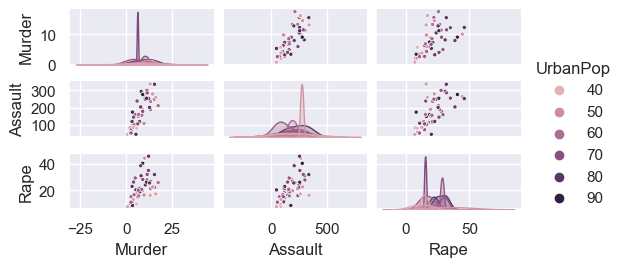

In [2]:
#%%
# 0. Carga de datos 
# -----------------------------------------------------------------------------
url_file = "https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv"
violent_crime = pd.read_csv(url_file)

# 1. Exploración inicial
df = violent_crime.copy()
namecols = df.columns
df = df.drop(['Unnamed: 0'],axis=1)
print(df.info())
target = 'UrbanPop';

# 2. Visualizacion de datos cols respecto al tiempo y
sns.pairplot(df,markers='.',diag_kind='kde',hue=target,height=.9,aspect=2)


In [3]:
#%%
# Preparacion de los datos
# -----------------------------------------------------------------------------
prop_test_size = 0.15
# target = 'categoria';
X = df.drop(target,axis=1); X = np.array(X);
y = df[target]; y = np.array(y);

# Estandarización (media cero y variancia 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform( y.reshape((len(y),1)) ).reshape(len(y))
             

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prop_test_size)
print('Son {} datos para entrenamiento y {} datos para prueba'.
      format(X_train.shape[0], X_test.shape[0]))


Son 42 datos para entrenamiento y 8 datos para prueba


## 1. Clustering K-means
Se analizan diferentes métricas para poder elegir un valor adecuado para la cantidad de cluster.
Las métricas evaluadas son:

**Score SDD - Inertia** - kmeans implementa esta métrica via el método score()
- Es la suma de las distancias al cuadrado (SDD) entre cada patrón y el centroide más cercano.
- Mide la dispersión de los patrones respecto de los centroides. Mas que una medida de la calidad de un modelo de agrupamiento, permite contrastar distintitas corridas de KMeans con diferentes configuraciones.
- Valores pequeños indican que los patrones están más cerca de sus respectivos centroides.

**Coeficiente de Silueta**
- Cuantifica la cohesión y separación de los clústeres en un conjunto de datos. Proporciona una medida de qué tan bien separados están los clústeres.
- El valor del coeficiente de silueta varía entre -1 y 1, donde un valor alto indica que los patrones están bien dentro de sus clústeres y bastante separados de otros clústeres. Esta métrica es útil para evaluar la calidad de un agrupamiento cuando no se dispone de las etiquetas reales.

**Distancia Davies-Bouldin**
- Mide la "compacidad" y "separación" de los clusters. 
- Valores más bajos indican clusters más compactos y bien separados.

**Índice Calinski-Harabasz** 
- Medida que compara la varianza entre los clusters con la varianza dentro de los clusters.
- Valores más altos indican clusters más densos y mejor definidos. 

In [4]:
#%%
# =============================================================================
# Ajuste manual Kmeans
# =============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
import warnings
warnings.filterwarnings("ignore")

N = 25; #clusters_max;
nro_clus            = np.zeros((N-1,1));
score               = np.zeros((N-1,1));
silhouette_score    = np.zeros((N-1,1));
db_score            = np.zeros((N-1,1)); # Distancia Davies-Bouldin
ch_score            = np.zeros((N-1,1)); # Índice Calinski-Harabasz

t1 = time.time();
for i in range(N-1):
    kmeans = KMeans(n_clusters=i+2, init='k-means++', random_state=1)
    kmeans.fit(X)
    labels_pred = kmeans.predict(X)
    
    nro_clus[i] = i+2; 
    score[i] = kmeans.score(X)
    silhouette_score[i] =  metrics.silhouette_score(X, labels_pred)
    db_score[i] = davies_bouldin_score(X, labels_pred)
    ch_score[i] = calinski_harabasz_score(X, labels_pred)

db_score = db_score/db_score.max()
ch_score = ch_score/ch_score.max()
t2 = time.time();

print('Tiempo de ajuste del modelo para ' ,N-1, ' distintos clusters ', 1000*round(t2-t1,6),'[ms]\n')


Tiempo de ajuste del modelo para  24  distintos clusters  33031.92 [ms]



## Resultados
Para la selección adecuada de la cantidad de clusters se evaluó la respuesta de k-means para distintos numeros de clusters.
En siguiente gráfico, se muestra el resultado de las métricas analizadas. Para el _scoreSDD_ (normalizado a [0,1]), _Coeficiente de Silueta_ e _Indice Calinski-Harabasz_ se marcan los tres valores máximos, y para la _Distancia de Davies-Bouldin_ se marcan los tres valores mínimos. 
Esto permite proponer como cantidad adecuada de clusters a **3** o **4**.

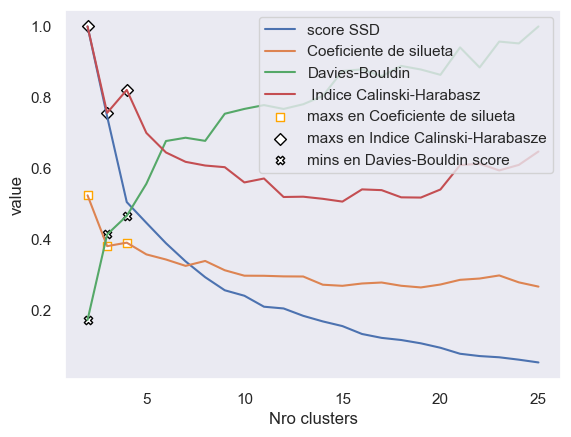

In [5]:
#%%
# Armado df de metricasy Plots
# -----------------------------------------------------------------------------
df_m = np.concatenate([nro_clus,score/score.min(),silhouette_score,
                      db_score,ch_score],axis=1)
df_m = pd.DataFrame(df_m,
      columns=['Nro clusters','score SSD','Coeficiente de silueta',
               'Davies-Bouldin',' Indice Calinski-Harabasz'])
metricas = df_m.melt('Nro clusters',var_name='Medidas')

_,ax = plt.subplots()
sns.lineplot(metricas,x='Nro clusters',y='value',hue='Medidas',ax=ax)
ax.grid()

#%
# Marcas indicando valores criticos
npts = 3;
ind = np.argsort(silhouette_score,axis=0)[-npts:];
xmax = nro_clus[ind.reshape(len(ind))]; ymax = silhouette_score[ind.reshape(len(ind))]
ax.scatter(xmax,ymax,c='w',edgecolors='orange', marker='s',label='maxs en Coeficiente de silueta')

ind = np.argsort(ch_score,axis=0)[-npts:]
xmax = nro_clus[ind.reshape(len(ind))]
ymax = ch_score[ind.reshape(len(ind))]
ax.scatter(xmax,ymax,c='w',edgecolors='black', marker='D',label='maxs en Indice Calinski-Harabasze')

ind = np.argsort(db_score,axis=0)[:npts]
xmax = nro_clus[ind.reshape(len(ind))]
ymax = db_score[ind.reshape(len(ind))]
ax.scatter(xmax,ymax,c='w',edgecolors='black',marker='X',label='mins en Davies-Bouldin score')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')

## Método del codo (Elbow Method)

Buscando info en la web, se encontró la  librería  _yellowbrick.cluster_ que devuelve la cantidad de clusters donde se produce el codo (cambio repentino en la evolución del scoreSDD). Esta Liberia también proporciona la gráfica del score SDD, tiempo de computo de k-means y el valor propuesto del codo.

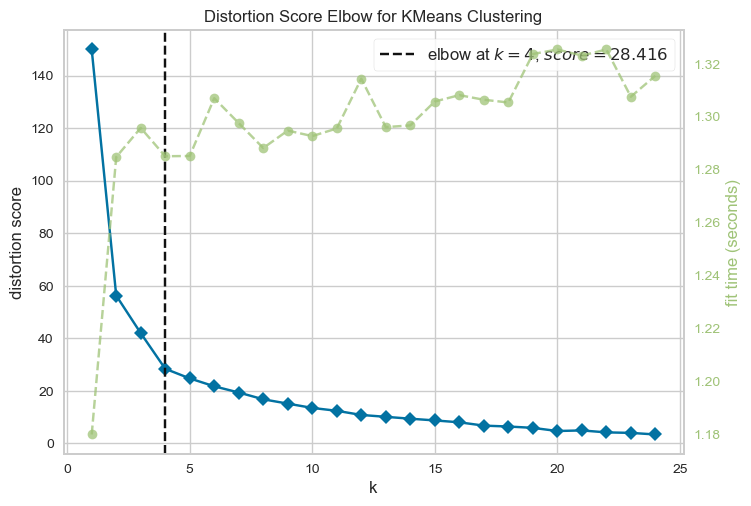

In [6]:
#%%
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

clusters_max = N
model = KMeans()
_,ax=plt.subplots()
visualizer = KElbowVisualizer(model, k=(1,clusters_max))
visualizer.fit(X)        # Entrenamos con los datos
visualizer.show()        # Renderizamos la imagen
ax.set_xlabel('Nro clusters'); ax.set_ylabel('SDD score'); 


## 2. Clustering Jerarquico
Segundo metodo de clustering analizado. 


In [7]:
import scipy.cluster.hierarchy as hc
%matplotlib notebook
p = 5;
metodo = 'ward';
truncar = 'lastp'; # 'lastp','level'

distancias = hc.linkage(X,method=metodo);

## Resultados
A partir del siguiente dendograma, observando las distancias (sobre el eje vertial) entre los clusters que se van fusionando, una propuesta adecuada para la cantidad de clusters es **4** o **5**.

<IPython.core.display.Javascript object>


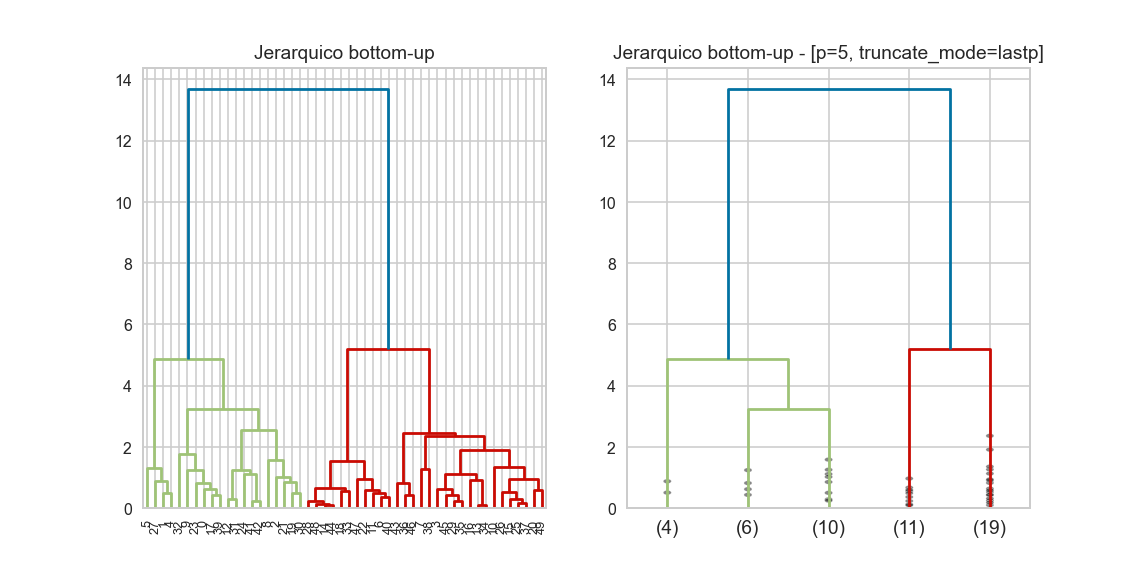

In [8]:
_,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5));

hc.dendrogram(distancias,ax=ax1);
ax1.set_title(f'Jerarquico bottom-up')

hc.dendrogram(distancias,p, truncar, show_contracted=True,ax=ax2);
ax2.set_title(f'Jerarquico bottom-up - [p={p}, truncate_mode={truncar}]');